In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from sklearn.utils.class_weight import compute_class_weight

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers, models 
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.models import load_model

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
data_dir = '../dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)   
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
data_dir = pd.concat([Fseries, Lseries], axis= 1)
data_dir

,filepaths,labels
0,../dataset\21060451_NguyenHungAnh\0.jpg,21060451_NguyenHungAnh
1,../dataset\21060451_NguyenHungAnh\1.jpg,21060451_NguyenHungAnh
2,../dataset\21060451_NguyenHungAnh\10.jpg,21060451_NguyenHungAnh
3,../dataset\21060451_NguyenHungAnh\100.jpg,21060451_NguyenHungAnh
4,../dataset\21060451_NguyenHungAnh\101.jpg,21060451_NguyenHungAnh
...,...,...
2865,../dataset\21119631_NguyenMinhLong\95.jpg,21119631_NguyenMinhLong
2866,../dataset\21119631_NguyenMinhLong\96.jpg,21119631_NguyenMinhLong
2867,../dataset\21119631_NguyenMinhLong\97.jpg,21119631_NguyenMinhLong
2868,../dataset\21119631_NguyenMinhLong\98.jpg,21119631_NguyenMinhLong


In [18]:
# train dataframe
train_df, dummy_df = train_test_split(data_dir,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [19]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(
    rescale=1 / 255., 
    rotation_range=10,        # Randomly rotate images within the range [-30, 30] degrees
    width_shift_range=0.1,    # Shift images horizontally within [-20%, 20%]
    height_shift_range=0.1,   # Shift images vertically within [-20%, 20%]
    zoom_range=0.2,           # Randomly zoom in or out
    fill_mode="nearest"       # Fill in missing pixels using the nearest method
)

ts_gen = ImageDataGenerator(
    rescale=1 / 255., 
)  # No augmentation for the test set

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 2296 validated image filenames belonging to 6 classes.
Found 344 validated image filenames belonging to 6 classes.
Found 230 validated image filenames belonging to 6 classes.


In [20]:
test_gen.class_indices

{'21060451_NguyenHungAnh': 0,
 '21090261_DuongNgocAnh': 1,
 '21094341_ChauTieuLong': 2,
 '21096911_NguyenNhatTung': 3,
 '21105351_TongThanhLoc': 4,
 '21119631_NguyenMinhLong': 5}

In [6]:
# Extract class labels for all instances in the training dataset
classes = np.array(train_gen.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 0.9333333333333333, 1: 0.9786871270247229, 2: 0.9495450785773366, 3: 0.9786871270247229, 4: 1.2424242424242424, 5: 0.9737065309584394}


In [11]:
from tensorflow.keras.applications import ResNet50V2

ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(128,128,3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

# Freezing all layers except last 50

ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

def Create_ResNet50V2_Model():

    model = Sequential([
                      ResNet50V2,
                      Dropout(0.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(0.5),
                      Dense(31,activation='softmax')
                    ])
    return model

model = Create_ResNet50V2_Model()
model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 4, 4, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4, 4, 2048)     │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,097,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 31)             │         2,015 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,672,479 (97.93 MB)

 Trainable params: 18,455,711 (70.40 MB)

 Non-trainable params: 7,216,768 (27.53 MB)

In [8]:
os.makedirs('model_checkpoint', exist_ok=True)
cnn_path='../model'
name = 'ResNet50V2_model.keras'
chk_path = os.path.join(cnn_path, name)
chk_path

'../model\\ResNet50V2_model.keras'

In [9]:
# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')
# Callback for early stopping
earlystop = EarlyStopping(monitor='accuracy',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True)

callbacks = [checkpoint, earlystop]

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    class_weight=class_weights_dict,
    callbacks=callbacks)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
model.save('../model/ResNet50V2.h5')

In [ ]:
import seaborn as sns
# Generate predictions for the test set
predictions = model.predict(test_generator)

# Get the predicted class indices
predicted_classes = np.argmax(predictions, axis=1)

# Get the true class indices
true_classes = test_generator.classes

# Ensure that the number of true classes and predicted classes are the same
assert len(true_classes) == len(predicted_classes), "Mismatch in the number of samples between true and predicted classes"

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
class_labels = list(test_generator.class_indices.keys())

# Generate and print the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

In [3]:
# Load the saved model
model = load_model('../model/restnet50v2.keras')  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


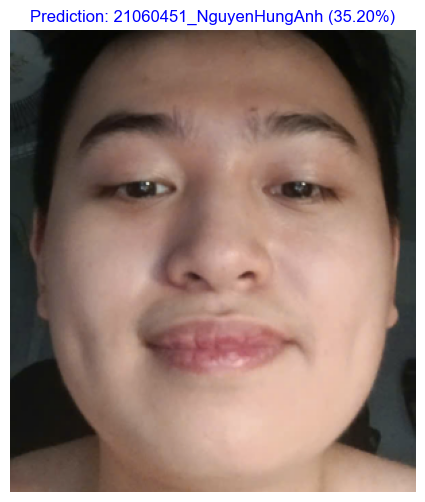

In [25]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Đường dẫn đến ảnh
image_path = "C:/Users/hung0/Downloads/Screenshot 2025-04-04 101743.png"
image = Image.open(image_path).convert('RGB')  # <- thêm .convert('RGB')


# Tiền xử lý ảnh
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Thêm batch dimension
img_array = preprocess_input(img_array)

# Dự đoán
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Lấy nhãn dự đoán
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
predicted_label = classes[np.argmax(score)]
confidence = 100 * np.max(score)

# Hiển thị hình ảnh và nhãn dự đoán
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis("off")
plt.title(f"Prediction: {predicted_label} ({confidence:.2f}%)", fontsize=12, color='blue')
plt.show()


In [ ]:
import cv2
import tensorflow as tf
import numpy as np
# Lấy danh sách nhãn
student_ids = {
    '21060451_NguyenHungAnh': 0,
    '21090261_DuongNgocAnh': 1,
    '21094341_ChauTieuLong': 2,
    '21096911_NguyenNhatTung': 3,
    '21105351_TongThanhLoc': 4,
    '21119631_NguyenMinhLong': 5
}

g_dict = student_ids 
classes = list(g_dict.keys())

# Load bộ phát hiện khuôn mặt Haarcascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Mở webcam
cap = cv2.VideoCapture(0)  # 0 là webcam mặc định

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Chuyển ảnh sang grayscale để tăng hiệu suất phát hiện khuôn mặt
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Phát hiện khuôn mặt
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(50, 50))

    for (x, y, w, h) in faces:
        # Cắt vùng khuôn mặt
        face = frame[y:y+h, x:x+w]

        # Tiền xử lý ảnh khuôn mặt
        face_resized = cv2.resize(face, (224, 224))  # Resize về 224x224
        img_array = tf.keras.preprocessing.image.img_to_array(face_resized)
        img_array = tf.expand_dims(img_array, axis=0)  # Thêm batch dimension
        img_array = preprocess_input(img_array)

        
        # Dự đoán
        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])

        # Lấy nhãn dự đoán
        predicted_label = classes[np.argmax(score)]
        confidence = 100 * np.max(score)

        # Vẽ hình chữ nhật xung quanh khuôn mặt
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Hiển thị nhãn dự đoán
        text = f"{predicted_label} ({confidence:.2f}%)"
        cv2.putText(frame, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    # Hiển thị khung hình
    cv2.imshow("Face Recognition", frame)

    # Thoát khi nhấn 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


NameError: name 'loaded_model' is not defined